DS Assesment - solution

Author: Malwina Gądek

In [1]:
import codecs
import gensim
import import_ipynb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import spacy
import seaborn as sns

from bs4 import BeautifulSoup
from xgboost import XGBClassifier
from gensim.models import Word2Vec, phrases
from language_detector import detect_language
from sklearn import utils
from sklearn.feature_extraction.text import CountVectorizer,  TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from wordcloud import WordCloud, STOPWORDS

from cleaning_functions import *

importing Jupyter notebook from cleaning_functions.ipynb


### Read data

In [2]:
train = pd.read_csv("train.csv")
print(train.shape)
train.head(n=3)

(100, 3)


url  doc_id  label
0  http://elbe-elster-klinikum.de/fachbereiche/ch...       1      1
1  http://klinikum-bayreuth.de/einrichtungen/zent...       3      3
2  http://klinikum-braunschweig.de/info.php/?id_o...       4      1

In [3]:
test = pd.read_csv("test.csv")
print(test.shape)
test.head(n=3)

(48, 2)


url  doc_id
0  http://chirurgie-goettingen.de/medizinische-ve...       0
1  http://evkb.de/kliniken-zentren/chirurgie/allg...       2
2  http://krebszentrum.kreiskliniken-reutlingen.d...       7

In [4]:
keywords = pd.read_csv("keyword2tumor_type.csv")
print(keywords.shape)
keywords.head(n=3)

(126, 2)


keyword tumor_type
0  senologische      Brust
1  brustzentrum      Brust
2        breast      Brust

### Preprocessing

#### To read html files I am using BeautifulSoup. Having extarcted text, I start data cleaning: removing html tags, punctuation, single letters, digits, and lowering all letters to have coherent data. Then, I am checking language of text (all in german). Finally, knowing language of text, I am removing stopwords and stemming text).

In [5]:
def get_text_from_html(file_id):
    """Function to read html.
    
    Args:
        file_id: name of html_file
        
    Returns:
        Text from html file.
    """
    try:
        f = codecs.open(f'htmls/{file_id}.html', 'r', encoding='utf-8', errors='ignore')
        document = BeautifulSoup(f.read(), features="lxml").get_text()
        soup = BeautifulSoup(document, features="lxml")
        text = soup.get_text()
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            raise
    
    return text

In [6]:
def text_preprocessing_step1(texts):
    """
    Functions to clean text.
    
    Args:
        texts: raw text
        
    Returns:
        Cleaned text.
    """
    
    texts = texts.apply(remove_html_tags)
    texts = texts.apply(remove_punctuation)
    texts = texts.apply(get_lower_texts)
    texts = texts.apply(remove_single_letters)
    texts = texts.apply(remove_digits)
    
    return texts

In [10]:
def language_detection(texts):
    """
    Detection of language.
    
    Args:
        texts: cleaned text
    
    Returns:
        Detected language.
    """
    
    return texts.map(lambda x: detect_language(x), na_action='ignore')

In [9]:
def text_preprocessing_step2(df):    
    """Remove stopwords, apply stemming specific for language.
    
    Args:
        df: pandas dataframe
        
    Returns:
        pandas dataframe with new columns.
    """
    
    df['cleaned_text'] = df.apply(lambda x: remove_stopwords(x.preprocessed_text, x.text_language), axis=1)
    df['ready_text'] = df.apply(lambda x: get_stemmed_text(x.cleaned_text, x.text_language), axis=1)
    
    return df

In [7]:
def preprocessing_pipeline(df):
    
    # 1. Extracting text from html files
    df["raw_text"] = df.doc_id.apply(get_text_from_html)
    
    # 2. Cleaning text
    df['preprocessed_text'] = text_preprocessing_step1(df.raw_text)

    # 3. Detecting language
    df['text_language'] = language_detection(df.preprocessed_text)
    # gives Russian for 2 texts, I checked manually and they are in German, so I change value for the whole column to German
    df['text_language'] = "de"

    # 4. Remove stopwords, apply stemming specific for language
    df = text_preprocessing_step2(df)
    
    return df

### Text model

#### To transform text I am using here TF-IDF and Word2Vec models.

In [8]:
# word2vec model

def word_averaging(model, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in model.wv.vocab:
            mean.append(model.wv.syn0[model.wv.vocab[word].index])
            all_words.add(model.wv.vocab[word].index)

    if not mean:
        print("Cannot compute similarity with no input %s", words)
        return np.zeros(model.wv.vector_size,)

    return gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)

def word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list])

def w2v_tokenize_text(text):
    '''
    Returns list of tokens.
    '''
    tokens = [word for word in text.split() if len(word)>1]
    return tokens

def generate_w2v_model(sentences, vector_size = 1000, skip_gram=0, use_bigrams=False):    
    '''
    Implementation of Word2Vec model.
    
    Args: 
        sentences: input text data
        vector_size: length of each vector
        skip_gram: which model to us, 0 -> cbow model used, 
                   skip_gram=0 -> cbow model used,
                   skip_gram=1 -> skip-gram model used
        use_bigrams: boolean argument to specify if user wants to use bigrams
    
    Returns:
        Trained w2v model.
    '''
    if use_bigrams:
        bigrams = phrases.Phrases(sentences)
        data = bigrams[sentences]
    else:
        data = sentences

    w2v_model = Word2Vec(min_count=2, window=3, size=vector_size, alpha=0.05, min_alpha=0.0007, workers=-1, sg=skip_gram)
    w2v_model.build_vocab(data)

    for epoch in range(30):
        w2v_model.train(utils.shuffle(data), total_examples=len(data), epochs=10)
        w2v_model.alpha -= 0.002
        w2v_model.min_alpha = w2v_model.alpha
    
    print("Vocab size:", len(w2v_model.wv.vocab))
    
    return w2v_model

In [11]:
# TF-IDF model

def generate_tfidf_model(data, percentage=100, ngram=1):
    """Applies tfidf model on text.
    
    Args:
        data: whole text data to train model
        percentage: percentage of vocabulary user want to use
        ngram: to specify range of ngrams
    
    Returns:
        Trained tfidf model.
    """
    
    cv = CountVectorizer(analyzer='word', token_pattern='[a-zA-Z]{2,}', ngram_range=(1, ngram))  
    cv.fit(data)
    
    vocab_size = int(percentage*len(cv.get_feature_names())/100)
    print('Vocab_size: ', vocab_size)
    
    tfidf_model = TfidfVectorizer(analyzer='word', token_pattern='[a-zA-Z]{2,}', ngram_range=(1, ngram), max_features=vocab_size)
    tfidf_model.fit(data)
    
    return tfidf_model

### Feature

#### Adding simple feature with number of occurences provided keaywords within each text.

In [12]:
keywords['stemmed_keyword'] = keywords.apply(lambda x: get_stemmed_text(x.keyword, 'de'), axis=1)
keywords.head()

keyword tumor_type stemmed_keyword
0  senologische      Brust         senolog
1  brustzentrum      Brust    brustzentrum
2        breast      Brust          breast
3        thorax      Brust          thorax
4     thorakale      Brust        thorakal

In [13]:
keywords_list = list(keywords.stemmed_keyword)
keywords_list

['senolog',
 'brustzentrum',
 'breast',
 'thorax',
 'thorakal',
 'brustkonferenz',
 'rektum',
 'colorec',
 'viszeralchirurgi',
 'visceralonkolog',
 'colon',
 'viszeralchirurg',
 'darmkrebszentrum',
 'kolorektal',
 'dunndarm',
 'darmkreb',
 'endomet',
 'endokrin',
 'endometria',
 'malignom',
 'neuroendokrin',
 'gall',
 'blasentumor',
 'viszeralmedizin',
 'gynakolog',
 'gynakoonkologi',
 'cervica',
 'genyco',
 'vagina',
 'uterin',
 'ovarian',
 'gynakolog',
 'bladd',
 'dermatolog',
 'dermo',
 'melanoma',
 'haut',
 'skin',
 'hautkreb',
 'hauttumor',
 'penil',
 'testicula',
 'leukami',
 'myeloid',
 'lympho',
 'leukemia',
 'hodgkin',
 'hamatolog',
 'hamatologi',
 'aug',
 'hno-tumor',
 'kopf-hal',
 'parathyroid',
 'thyroid',
 'mediastinal',
 'leb',
 'liv',
 'lungenszintigrafi',
 'lungenzirkel',
 'lungentumorkonferenz',
 'lungenkreb',
 'pneumolog',
 'lungenkrebszentrum',
 'lungenkarzinom',
 'lungenszintigrafi',
 'lungeninhalation',
 'lungenqualitatszirkel',
 'transit',
 'gastroenterologi',
 's

In [14]:
def add_feature(df, keywords_list):
    """
    Function to add column with number of occurences words from keaywords_list in each text
    """
    df['Keywords'] = df.ready_text.apply(lambda x: sum(1 for word in x.split() if word in keywords_list))
    
    return df

### Train set

In [22]:
# text extraction and preprocessing
df_train = preprocessing_pipeline(train)

In [23]:
# check if we have some empty cells
df_train[df_train.isnull().any(axis=1)]

Empty DataFrame
Columns: [url, doc_id, label, raw_text, preprocessed_text, text_language, cleaned_text, ready_text]
Index: []

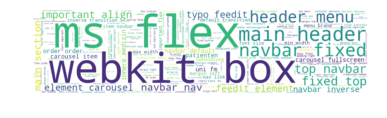

In [24]:
# visualization of vocabulary in training data
text_train = " ".join(text for text in df_train.ready_text)
make_wordcloud(text_train, 'preprocessed_training_set')

In [25]:
data_to_text_model = df_train.ready_text 
sentences = [row.split() for row in data_to_text_model]

In [26]:
# fit word2vec language model
w2v_model = generate_w2v_model(sentences, use_bigrams=True)

Vocab size: 13196


In [27]:
# fit TF-IDF language model
tfidf_model = generate_tfidf_model(data_to_text_model, 20, 2)

Vocab_size:  18924


In [31]:
# make feature vectors using word2vec model
text_tokenized_train = df_train.ready_text.apply(lambda x: w2v_tokenize_text(x)).values
text_word_average_train = word_averaging_list(w2v_model, text_tokenized_train)

c:\users\malwina\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  # Remove the CWD from sys.path while we load stuff.


In [30]:
# make text features with tfidf model
text_features_tfidf_train = tfidf_model.transform(df_train.ready_text.values)

In [28]:
# generate feature
df_train = add_feature(df_train, keywords_list)

In [29]:
# get max value of new feature
max_occurence = df_train.Keywords.max()
max_occurence

89

In [32]:
# normalize feature values
df_train['Keywords_normalized'] = round(df_train['Keywords'] / max_occurence, 3)
df_train

url  doc_id  label  \
0   http://elbe-elster-klinikum.de/fachbereiche/ch...       1      1   
1   http://klinikum-bayreuth.de/einrichtungen/zent...       3      3   
2   http://klinikum-braunschweig.de/info.php/?id_o...       4      1   
3   http://klinikum-braunschweig.de/info.php/?id_o...       5      1   
4   http://klinikum-braunschweig.de/zuweiser/tumor...       6      3   
5   http://krebszentrum.kreiskliniken-reutlingen.d...       8      1   
6   http://krebszentrum.kreiskliniken-reutlingen.d...       9      1   
7   http://krebszentrum.kreiskliniken-reutlingen.d...      10      1   
8   http://krebszentrum.kreiskliniken-reutlingen.d...      11      1   
9   http://krebszentrum.kreiskliniken-reutlingen.d...      12      1   
10  http://krebszentrum.kreiskliniken-reutlingen.d...      13      2   
11  http://marienhospital-buer.de/mhb-av-chirurgie...      14      2   
12  http://marienhospital-buer.de/mhb-av-chirurgie...      17      2   
13  http://marienhospital-buer.de/mhb-av-chirurgie...      18      2   
14  http://marienhospital-buer.de/mhb-tumorzentrum...      19      2   
15  http://marienhospital-buer.de/mhb-tumorzentrum...      20      2   
16               http://marienhospital.eu/1454/?l=770      21      2   
17               http://marienhospital.eu/4648/?l=662      22      2   
18  http://neurochirurgie.uk-koeln.de/erkrankungen...      23      1   
19  http://rendsburg.imland.de/de/thoraxchirurgie_...      25      3   
20  http://rotkreuzklinikum-muenchen.de/medizin-un...      26      2   
21  http://siloah.krh.de/kliniken-zentren/darmkreb...      27      2   
22  http://stereotaxie.uk-koeln.de/erkrankungen-th...      28      2   
23  http://www.2017.kreiskliniken-reutlingen.de/kl...      29      2   
24  http://www.alb-fils-kliniken.de/radiologie-und...      30      2   
25  http://www.barmherzige-muenchen.de/allgemein-u...      33      2   
26  http://www.barmherzige-muenchen.de/innere-medi...      34      1   
27  http://www.barmherzige-regensburg.de/geriatris...      35      1   
28  http://www.barmherzige-regensburg.de/onkologie...      37      1   
29  http://www.bethesda-krankenhaus-duisburg.de/kl...      40      2   
..                                                ...     ...    ...   
70  http://www.malteser-kliniken-rhein-ruhr.de/med...     107      2   
71  http://www.malteser-kliniken-rhein-ruhr.de/med...     108      2   
72  http://www.marien-hospital.de/behandlungsangeb...     110      2   
73  http://www.marienhospital-oelde.de/medizin/med...     111      2   
74  http://www.marienhospital-stuttgart.de/aerzte-...     112      1   
75  http://www.mri.tum.de/muskuloskelettales-tumor...     114      2   
76  http://www.muenchen-klinik.de/krankenhaus/boge...     115      2   
77  http://www.nct-dresden.de/en/research/nct-mast...     117      1   
78  http://www.nct-heidelberg.de/das-nct/newsroom/...     118      2   
79  http://www.nct-heidelberg.de/en/research/nct-c...     119      2   
80  http://www.neurochirurgie.uk-erlangen.de/forsc...     120      1   
81  http://www.petrus-krankenhaus-wuppertal.de/med...     121      2   
82  http://www.petrus-krankenhaus-wuppertal.de/med...     122      2   
83  http://www.sbk-vs.de/de/medizin/leistungen-und...     125      1   
84  http://www.sfh-muenster.de/unsere-kompetenzen/...     126      2   
85  http://www.st-vincenz.de/medizinische-kompeten...     128      2   
86  http://www.thoraxklinik-heidelberg.de/?fs=0&id...     129      2   
87  http://www.thoraxklinik-heidelberg.de/?fs=1%25...     130      2   
88       http://www.thoraxklinik-heidelberg.de/?id=42     131      2   
89  http://www.thoraxklinik-heidelberg.de/?id=42&l...     132      2   
90  http://www.uk-augsburg.de/kliniken-und-institu...     133      2   
91   http://www.ukm.de/?id=hautklinik_veranstaltungen     136      2   
92  http://www.ukm.de/?id=kinder-knochen-weichteil...     137      1   
93       http://www.ukm.de/?id=neurochirurgie_aktuell     138      1   
94  http://www.uni

In [33]:
# join feature with word representation
feature = df_train['Keywords_normalized']
feature.shape, text_word_average_train.shape, text_features_tfidf_train.shape

((100,), (100, 1000), (100, 18924))

In [34]:
X_train_w2v = np.concatenate([text_word_average_train, feature[:, None]], axis=-1)
X_train_w2v.shape

(100, 1001)

In [35]:
X_train_tfidf = scipy.sparse.hstack([text_features_tfidf_train, feature[:, None]])
X_train_tfidf.shape

(100, 18925)

### Test set

In [36]:
# text extraction and preprocessing
df_test = preprocessing_pipeline(test)

In [37]:
# check if we have some empty cells
df_test[df_test.isnull().any(axis=1)]

Empty DataFrame
Columns: [url, doc_id, raw_text, preprocessed_text, text_language, cleaned_text, ready_text]
Index: []

In [38]:
# make feature vectors using word2vec model
text_tokenized_test = df_test.ready_text.apply(lambda x: w2v_tokenize_text(x)).values
text_word_average_test = word_averaging_list(w2v_model, text_tokenized_test)

c:\users\malwina\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  # Remove the CWD from sys.path while we load stuff.


In [39]:
# make text features with tfidf model
text_features_tfidf_test = tfidf_model.transform(df_test.ready_text.values)

In [40]:
# generate feature
df_test = add_feature(df_test, keywords_list)

In [41]:
# normalize feature values using max value from training set
df_test['Keywords_normalized'] = round(df_test['Keywords'] / max_occurence, 3)
df_test

url  doc_id  \
0   http://chirurgie-goettingen.de/medizinische-ve...       0   
1   http://evkb.de/kliniken-zentren/chirurgie/allg...       2   
2   http://krebszentrum.kreiskliniken-reutlingen.d...       7   
3   http://marienhospital-buer.de/mhb-av-chirurgie...      15   
4   http://marienhospital-buer.de/mhb-av-chirurgie...      16   
5   http://onkozentrum.med.uni-rostock.de/informat...      24   
6   http://www.asklepios.com/goslar/experten/haema...      31   
7   http://www.asklepios.com/hamburg/altona/expert...      32   
8   http://www.barmherzige-regensburg.de/herzrhyth...      36   
9   http://www.barmherzige-regensburg.de/zentrum-f...      38   
10  http://www.bbtgruppe.de/zentrale/projektueberg...      39   
11  http://www.chirurgie.uk-erlangen.de/aktuelles/...      43   
12  http://www.ctk.de/klinikum/karriere/stellenang...      46   
13  http://www.ctk.de/klinikum/kliniken-zentren/ze...      47   
14  http://www.diakovere.de/unternehmen-und-mehr/k...      50   
15  http://www.drk-kliniken-berlin.de/radiologie-k...      51   
16  http://www.evkln.de/kliniken-institute-zentren...      53   
17  http://www.gesundheit-nordhessen.de/en/zentrum...      56   
18  http://www.gesundheitnord.de/krankenhaeuserund...      58   
19  http://www.gesundheitszentrum-wetterau.de/342/...      59   
20  http://www.gfo-kliniken-bonn.de/fachabteilunge...      60   
21  http://www.gp-ruesselsheim.de/01_gpr_gruppe/02...      62   
22  http://www.helios-gesundheit.de/kliniken/schwe...      65   
23  http://www.helios-gesundheit.de/nrw/helios-tum...      66   
24  http://www.hjk-muenster.de/unsere-kompetenzen/...      68   
25  http://www.hufeland.de/de/abteilung-fuer-gastr...      69   
26  http://www.interdisziplinaere-endoskopie.mri.t...      70   
27  http://www.josephstift-dresden.de/pressemittei...      71   
28  http://www.klilu.de/medizin__pflege/kliniken_u...      74   
29  http://www.kliniksued-rostock.de/kliniken-abte...      78   
30  http://www.klinikum-esslingen.de/kliniken-und-...      82   
31  http://www.klinikum-esslingen.de/kliniken-und-...      84   
32  http://www.klinikum-esslingen.de/kliniken-und-...      87   
33  http://www.klinikum-oberberg.de/en/karriere-au...      91   
34  http://www.klinikverbund-suedwest.de/kliniken-...      99   
35  http://www.krupp-krankenhaus.de/allg-viszeralc...     103   
36  http://www.malteser-franziskus.de/medizin-pfle...     104   
37  http://www.maria-josef-hospital.de/unsere-komp...     109   
38   http://www.medizin.uni-halle.de/?bf=&id=2947&l=0     113   
39  http://www.muk.uni-frankfurt.de/pressemitteilu...     116   
40  http://www.pius-hospital.de/kliniken/gynaekolo...     123   
41  http://www.prosper-hospital.de/brustkrebs.1312...     124   
42  http://www.siemens-healthineers.com/de/digital...     127   
43  http://www.uk-augsburg.de/krebsbehandlung/diag...     134   
44  http://www.ukb.uni-bonn.de/42256bc8002af3e7/vw...     135   
45  http://www.uniklinikum-leipzig.de/einrichtunge...     142   
46  http://www.vidia-kliniken.de/job-und-karriere/...     143   
47  http://www.zollernalb-klinikum.de/medizin/klin...     147   

                                             raw_text  \
0   Bauchspeicheldrüse | Klinik für Allgemein-, Vi...   
1   Chirurgie der Bauchspeicheldrüse (Pankreaschir...   
2   Brustzentrum Reutlingen: Behandlungsverfahren ...   
3   Leistungsspektrum: Sankt Marien-Hospital Buer ...   
4   Leistungsspektrum: Sankt Marien-Hospital Buer ...   
5   Tumorzentrum Rostock e.V. – Onkologisches Zent...   
6   Gynäkologische Tumore - Asklepios Harzklinik G...   
7   Interdisziplinäre Tumorkonferenzen - Asklepios...   
8   Selbsthilfegruppen - Krankenhaus Barmherzige B...   
9   Stereotaktische Radiotherapie - Krankenhaus Ba...   
10  Interventionelle Radiologie - Mehr als nur Bil...   
11  Chirurgie\n\n\n\n\n\n\n\n\n\n\nNachrichten - U...   
12  Gesundheits- und Krankenpfleger/in (m/w/d) ode...   
13  Onkologisches Zentrum | Carl-Thiem-Klinikum Co...   
14  Konta

In [43]:
# join feature with word representation
feature = df_test['Keywords_normalized']
feature.shape, text_word_average_test.shape, text_features_tfidf_test.shape

((48,), (48, 1000), (48, 18924))

In [44]:
X_test_w2v = np.concatenate([text_word_average_test, feature[:, None]], axis=-1)
X_test_w2v.shape

(48, 1001)

In [45]:
X_test_tfidf = scipy.sparse.hstack([text_features_tfidf_test, feature[:, None]])
X_test_tfidf.shape

(48, 18925)

### Models

#### I am testing here SVM and XGBoost models, which performs usually well in NLP tasks. To pick optimal parameters, I am using GridSearch, with 5-folds cross validation to check models performance. I am comparing accuracies of the best performing models.

In [46]:
def train_with_GridSearch(model, X_train, X_test, y_train, file_name, test_doc_ids):

    # fit model
    model.fit(X_train, y_train)

    # pick the best model
    model_params = model.best_params_
    print('Best score for training data:', model.best_score_,"\n") 
    print('Best parameters:', model_params)
    final_model = model.best_estimator_
    
    # predict the labels on test dataset
    predictions =  final_model.predict(X_test)
    print('Predictions:', predictions)
    output = pd.DataFrame(list(zip(test_doc_ids, predictions)), columns=['doc_id', 'prediction'])
    
    # save predictions to csv
    output.to_csv(f'submission_{file_name}.csv', index=False)

In [47]:
# ids in testset to join with predictions
test_doc_ids = df_test.doc_id

In [48]:
labels = df_train.label

X_train_w2v.shape, X_train_tfidf.shape, len(labels)

((100, 1001), (100, 18925), 100)

In [54]:
params_grid_svm = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 500], 'class_weight': ['balanced', None]},
                   {'kernel': ['linear'], 'C': [1, 10, 100, 500], 'class_weight': ['balanced', None]}]

svm_model = GridSearchCV(SVC(probability=True), params_grid_svm, cv=5, n_jobs=15)

In [55]:
params_grid_xgb = [{'kernel': ['multi:softmax'], 'learning_rate': [0.05, 0.1], 'max_depth': [25, 50, 100], 'gamma': [2],
                    'n_estimators': [50, 100, 150], 'scale_pos_weight': [50], 'colsample_bytree': [0.6, 0.7, 0.8],
                    'tree_method': ['hist'], 'early_stopping_round': [3], 'nthreads': [4], 'n_jobs': [15]}]

xgb_model = GridSearchCV(XGBClassifier(probability=True), params_grid_xgb, cv=5, verbose=10, n_jobs=15)

##### Training models

In [56]:
train_with_GridSearch(svm_model, X_train_w2v, X_test_w2v, labels, "svm_w2v", test_doc_ids)

c:\users\malwina\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score for training data: 0.59 

Best parameters: {'C': 1, 'class_weight': None, 'gamma': 0.001, 'kernel': 'rbf'}
Predictions: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2]


In [57]:
train_with_GridSearch(svm_model, X_train_tfidf, X_test_tfidf, labels, "svm_tfidf", test_doc_ids)

c:\users\malwina\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score for training data: 0.59 

Best parameters: {'C': 1, 'class_weight': None, 'gamma': 0.001, 'kernel': 'rbf'}
Predictions: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2]


In [58]:
train_with_GridSearch(xgb_model, X_train_w2v, X_test_w2v, labels, "xgb_w2v", test_doc_ids)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:   35.4s
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:  1.8min
[Parallel(n_jobs=15)]: Done  31 tasks      | elapsed:  2.8min
[Parallel(n_jobs=15)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=15)]: Done  55 tasks      | elapsed:  4.6min
[Parallel(n_jobs=15)]: Done  68 tasks      | elapsed:  5.6min
[Parallel(n_jobs=15)]: Done  83 tasks      | elapsed:  6.7min
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:  7.8min
[Parallel(n_jobs=15)]: Done 115 tasks      | elapsed:  9.0min
[Parallel(n_jobs=15)]: Done 132 tasks      | elapsed: 10.2min
[Parallel(n_jobs=15)]: Done 151 tasks      | elapsed: 11.8min
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed: 13.5min
[Parallel(n_jobs=15)]: Done 191 tasks      | elapsed: 14.7min
[Parallel(n_jobs=15)]: Done 212 tasks      | elapsed: 1

Best score for training data: 0.6 

Best parameters: {'colsample_bytree': 0.7, 'early_stopping_round': 3, 'gamma': 2, 'kernel': 'multi:softmax', 'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 100, 'n_jobs': 15, 'nthreads': 4, 'scale_pos_weight': 50, 'tree_method': 'hist'}
Predictions: [2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1
 2 2 2 2 2 2 2 2 2 2 2]


In [59]:
train_with_GridSearch(xgb_model, X_train_tfidf, X_test_tfidf, labels, "xgb_tfidf", test_doc_ids)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:  3.1min
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:  4.6min
[Parallel(n_jobs=15)]: Done  31 tasks      | elapsed:  6.9min
[Parallel(n_jobs=15)]: Done  42 tasks      | elapsed:  8.5min
[Parallel(n_jobs=15)]: Done  55 tasks      | elapsed: 10.8min
[Parallel(n_jobs=15)]: Done  68 tasks      | elapsed: 13.3min
[Parallel(n_jobs=15)]: Done  83 tasks      | elapsed: 15.9min
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed: 19.0min
[Parallel(n_jobs=15)]: Done 115 tasks      | elapsed: 22.1min
[Parallel(n_jobs=15)]: Done 132 tasks      | elapsed: 25.3min
[Parallel(n_jobs=15)]: Done 151 tasks      | elapsed: 29.2min
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed: 33.5min
[Parallel(n_jobs=15)]: Done 191 tasks      | elapsed: 37.1min
[Parallel(n_jobs=15)]: Done 212 tasks      | elapsed: 4

Best score for training data: 0.61 

Best parameters: {'colsample_bytree': 0.6, 'early_stopping_round': 3, 'gamma': 2, 'kernel': 'multi:softmax', 'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 50, 'n_jobs': 15, 'nthreads': 4, 'scale_pos_weight': 50, 'tree_method': 'hist'}
Predictions: [2 2 1 2 2 2 2 2 1 1 2 1 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2
 2 2 1 2 2 2 2 2 2 2 2]


#### For training data, performances are almost equal, about 60%, but the best performance is for XGB model with tfidf text representation. Having accuracy about 60% on validation, I think that accuracy on test set can be about 50%. 

#### I think that algorithm is working fast, except last to trainings, it is already calculating in parallel, probably on stronger computer it will work fine.

#### Having more time I would dig more into structure of example htmls and filter only body of pages, without table of contents etc. It may improve performance. I would also think about additional features, maybe keywords divided by tumor category. I will also test other parameters making word representation, and test other libraries checking language of text. Having more data would be good to test performance building some CNN.

#### Writing code I was trying to take into account all potencial issues, but it may be that loading additional htlm there will be some issue, or values to test in GridSearch would be changed having more data.